# What if... I take all the features, run the VIF and fit the model with the filtered features?

In [72]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tinyshift.stats import BootstrapBCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score


In [73]:
df = pd.read_csv("./data/cancer_reg.csv", encoding='iso-8859-1')

In [74]:
df = df[df['MedianAge'] <= 90]

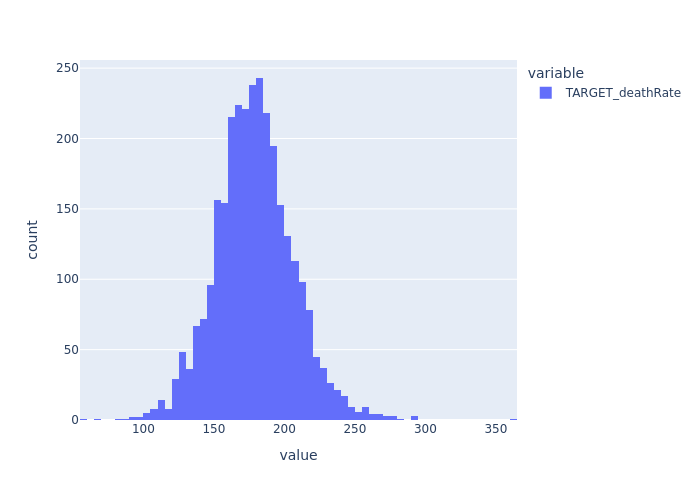

In [75]:
fig = px.histogram(df["TARGET_deathRate"])
fig.show("png")

In [76]:
df["TARGET_deathRate"].var() > df["TARGET_deathRate"].mean()

True

In [77]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

## Percentage of Total of NaN Data for Each Column

In [78]:
df.isnull().sum() / len(df)

avgAnnCount                0.000000
avgDeathsPerYear           0.000000
TARGET_deathRate           0.000000
incidenceRate              0.000000
medIncome                  0.000000
popEst2015                 0.000000
povertyPercent             0.000000
studyPerCap                0.000000
binnedInc                  0.000000
MedianAge                  0.000000
MedianAgeMale              0.000000
MedianAgeFemale            0.000000
Geography                  0.000000
AvgHouseholdSize           0.000000
PercentMarried             0.000000
PctNoHS18_24               0.000000
PctHS18_24                 0.000000
PctSomeCol18_24            0.750083
PctBachDeg18_24            0.000000
PctHS25_Over               0.000000
PctBachDeg25_Over          0.000000
PctEmployed16_Over         0.049387
PctUnemployed16_Over       0.000000
PctPrivateCoverage         0.000000
PctPrivateCoverageAlone    0.199536
PctEmpPrivCoverage         0.000000
PctPublicCoverage          0.000000
PctPublicCoverageAlone     0

In [79]:
df = df.drop(columns=["PctSomeCol18_24", "PctPrivateCoverageAlone"])

In [80]:
bca = BootstrapBCA()
bca.compute_interval(df["PctEmployed16_Over"].dropna(), confidence_level=0.95, statistic=np.mean, n_resamples=1000)

(53.82614569603778, 54.43873685962987)

In [81]:
df["PctEmployed16_Over"] = df["PctEmployed16_Over"].fillna(np.ceil(df["PctEmployed16_Over"].mean()))

In [82]:
features_in = [
"avgAnnCount",
"PctPrivateCoverage",
"PctPublicCoverage",
"PctBachDeg25_Over",
"PercentMarried",
"incidenceRate",
"povertyPercent",
"MedianAge",
"medIncome",
"PctWhite",
"PctBlack",
"PctAsian",
"PctOtherRace",
"avgDeathsPerYear",
"popEst2015",
]
target = "TARGET_deathRate"

In [83]:
df[features_in].corr(numeric_only=True)

,avgAnnCount,PctPrivateCoverage,PctPublicCoverage,PctBachDeg25_Over,PercentMarried,incidenceRate,povertyPercent,MedianAge,medIncome,PctWhite,PctBlack,PctAsian,PctOtherRace,avgDeathsPerYear,popEst2015
avgAnnCount,1.000000,0.131899,-0.172696,0.320376,-0.106759,0.074173,-0.135409,-0.122427,0.269259,-0.137040,0.031062,0.434301,0.209035,0.939652,0.927195
PctPrivateCoverage,0.131899,1.000000,-0.720787,0.603799,0.447052,0.108169,-0.822348,0.069183,0.723657,0.426759,-0.346055,0.190507,-0.176638,0.055904,0.052518
PctPublicCoverage,-0.172696,-0.720787,1.000000,-0.635660,-0.245513,0.045426,0.651187,0.426814,-0.754357,-0.135218,0.197391,-0.305129,-0.078100,-0.131152,-0.158992
PctBachDeg25_Over,0.320376,0.603799,-0.635660,1.000000,0.102124,-0.037710,-0.530799,-0.149707,0.704081,0.048379,-0.146751,0.437165,0.037923,0.292794,0.296521
PercentMarried,-0.106759,0.447052,-0.245513,0.102124,1.000000,-0.117804,-0.642055,0.430116,0.353561,0.677085,-0.623612,-0.149697,-0.104617,-0.181590,-0.161150
incidenceRate,0.074173,0.108169,0.045426,-0.037710,-0.117804,1.000000,0.008038,-0.004841,0.000262,-0.013590,0.114742,-0.007400,-0.206677,0.063082,0.027487
povertyPercent,-0.135409,-0.822348,0.651187,-0.530799,-0.642055,0.008038,1.000000,-0.193780,-0.788274,-0.509037,0.511933,-0.157409,0.046900,-0.066748,-0.064906
MedianAge,-0.122427,0.069183,0.426814,-0.149707,0.430116,-0.004841,-0.193780,1.000000,-0.117480,0.374095,-0.204706,-0.248687,-0.279139,-0.144721,-0.176375
medIncome,0.269259,0.723657,-0.754357,0.704081,0.353561,0.000262,-0.788274,-0.117480,1.000000,0.166044,-0.270238,0.426844,0.083702,0.223455,0.235422
PctWhite,-0.137040,0.426759,-0.135218,0.048379,0.677085,-0.013590,-0.509037,0.374095,0.166044,1.000000,-0.830564,-0.265512,-0.232864,-0.187637,-0.189898


In [84]:
model = LinearRegression()

In [85]:
model.fit(df[features_in], df[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [86]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train[target].std()
    return std_coef

In [87]:
model.feature_importance_ = standardize_coefficients(model, df)
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,avgDeathsPerYear,0.431373
1,incidenceRate,0.414719
2,povertyPercent,0.108115
3,medIncome,0.023876
4,PctPublicCoverage,0.018485
5,PctAsian,0.008786
6,PercentMarried,-0.002456
7,PctBlack,-0.016178
8,MedianAge,-0.046663
9,PctWhite,-0.066984


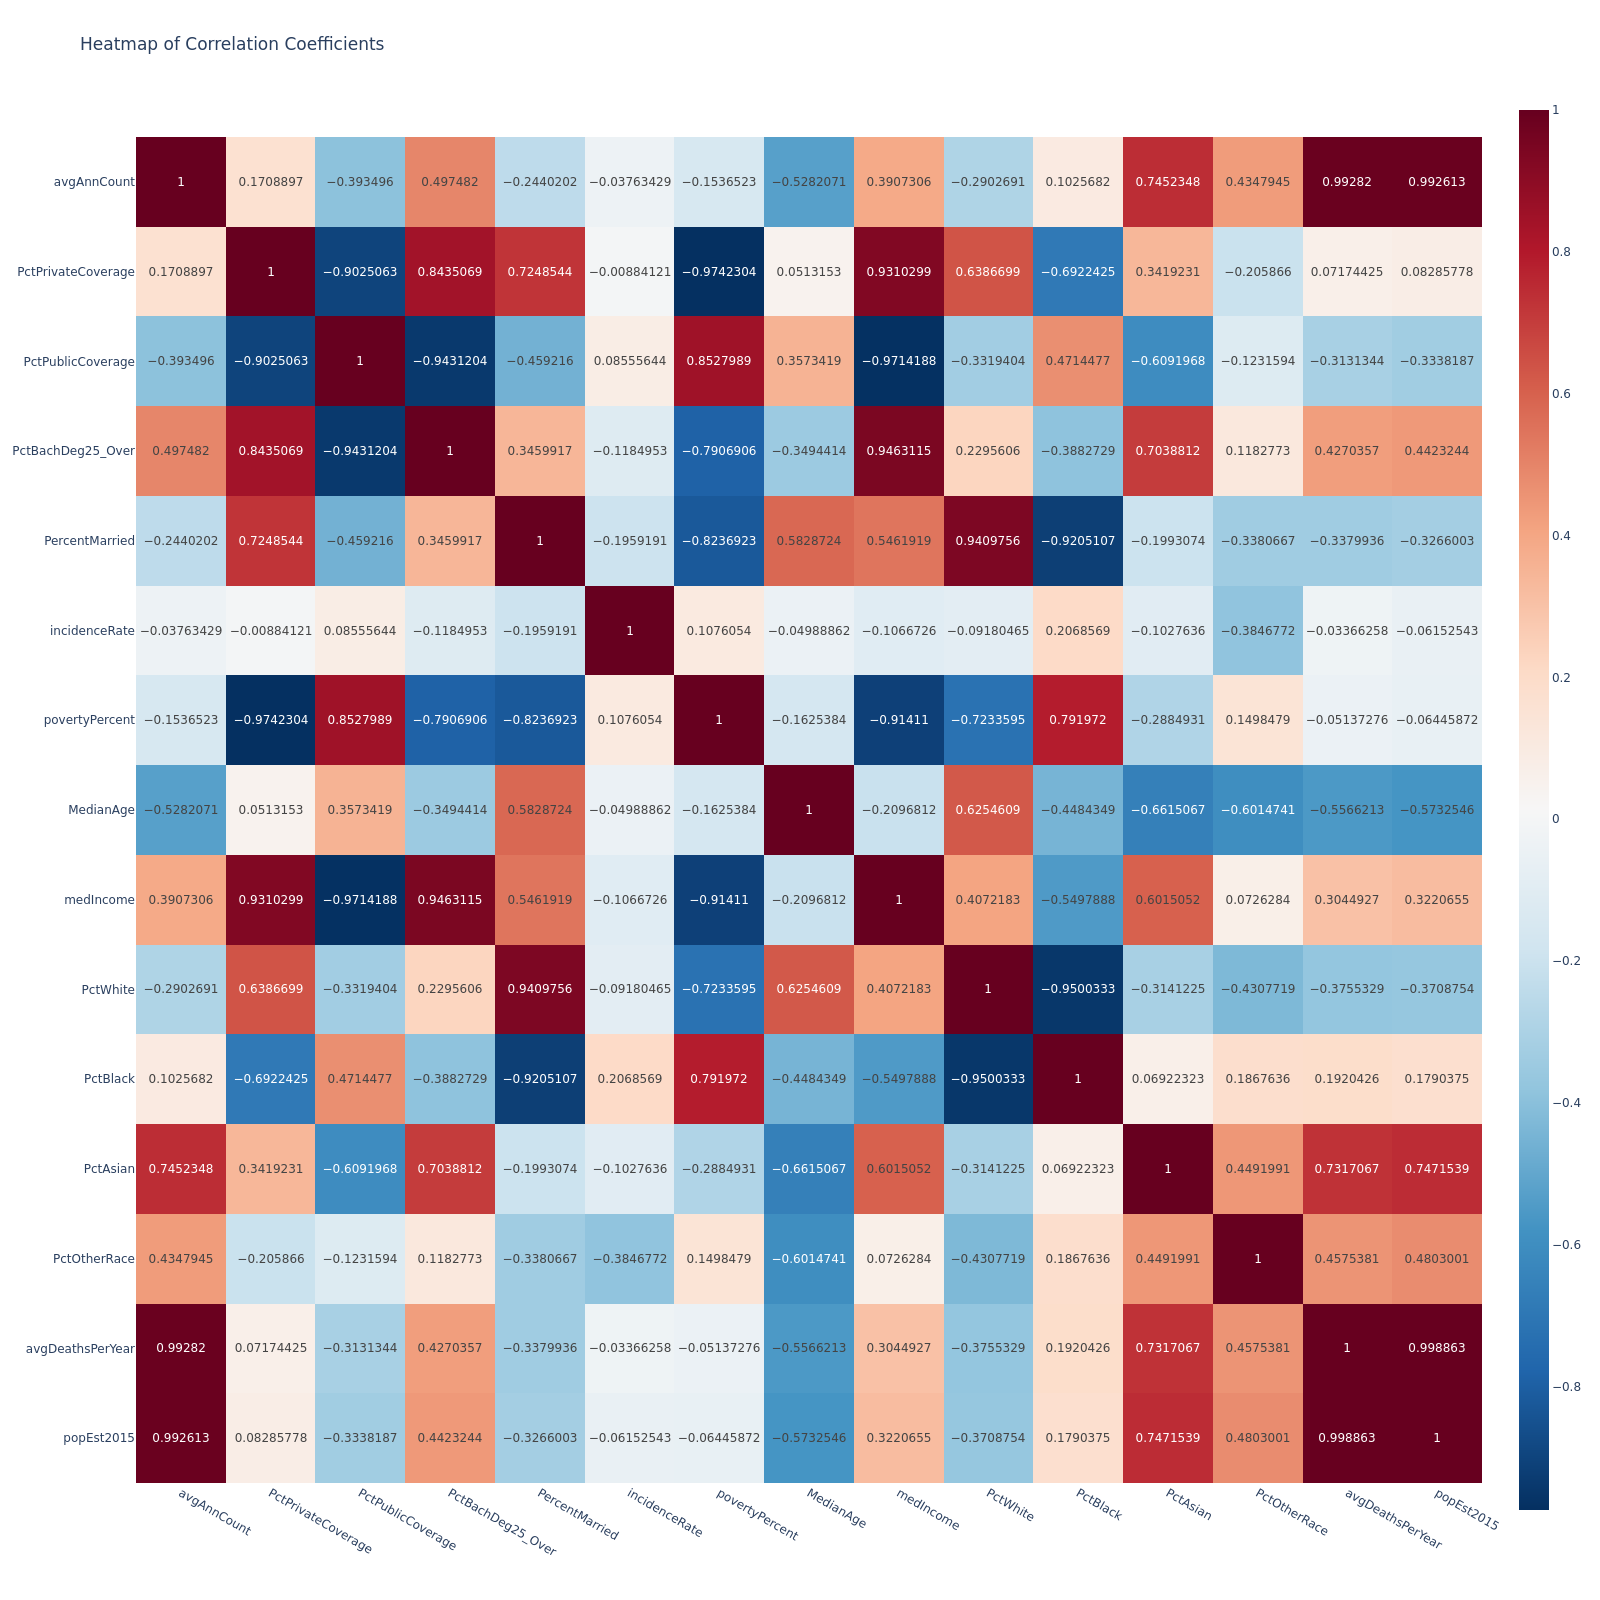

In [88]:
corr_heatmap(df[features_in].corr(numeric_only=True), fig_type="png")

In [89]:
df[features_in].corr(numeric_only=True).loc["avgDeathsPerYear"]

avgAnnCount           0.939652
PctPrivateCoverage    0.055904
PctPublicCoverage    -0.131152
PctBachDeg25_Over     0.292794
PercentMarried       -0.181590
incidenceRate         0.063082
povertyPercent       -0.066748
MedianAge            -0.144721
medIncome             0.223455
PctWhite             -0.187637
PctBlack              0.084196
PctAsian              0.442420
PctOtherRace          0.214894
avgDeathsPerYear      1.000000
popEst2015            0.977858
Name: avgDeathsPerYear, dtype: float64

In [90]:
features = ["avgAnnCount", "popEst2015"]

# Partialling-Out

In [91]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
import numpy as np

class PartiallingOutRegressor(BaseEstimator, RegressorMixin):
    """
    Regressor que aplica partialling-out (resíduos de uma regressão linear) antes da predição.
    
    Parâmetros:
    -----------
    features_to_partial_out : list ou array-like
        Lista de nomes (se X for DataFrame) ou índices das colunas a serem usadas
        para calcular os resíduos da variável target.
        
    fit_intercept : bool (default=True)
        Se True, o modelo de regressão linear auxiliar inclui intercepto.
    """
    
    def __init__(self):
        self.model = None 
        
    def fit(self, X, y):
        """
        Ajusta o modelo de partialling-out.
        
        Parâmetros:
        -----------
        X : array-like ou DataFrame (n_samples, n_features)
            Features, incluindo a variável a ser residualizada.
        y : array-like (n_samples,)
            Variável target.
        """

        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
            
        self.model = LinearRegression()
        self.model.fit(X, y)
        
        return self
    
    def generate_residuals(self, X, y):
        """
        Retorna os resíduos (partialling-out) da variável target.
        
        Parâmetros:
        -----------
        X : array-like ou DataFrame (n_samples, n_features)
            Features, incluindo as variáveis usadas no partialling-out.
        """
                    
        residuals = y - self.model.predict(X)

        return residuals
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

## IsolatedavgDeathPerYear

In [92]:
partialling_model = PartiallingOutRegressor()
partialling_model.fit(df[["avgAnnCount", "popEst2015"]], df["avgDeathsPerYear"])
avg_deaths_per_year = partialling_model.generate_residuals(df[["avgAnnCount", "popEst2015"]], df["avgDeathsPerYear"])

## IsolatedAvgAnnCount

In [93]:
partialling_model = PartiallingOutRegressor()
partialling_model.fit(df[["PctBachDeg25_Over", "medIncome", "PctAsian", "popEst2015"]], df["avgAnnCount"])
avg_ann_count = partialling_model.generate_residuals(df[["PctBachDeg25_Over", "medIncome", "PctAsian", "popEst2015"]], df["avgAnnCount"])

## IsolatedPctPrivateCoverage

In [94]:
cols = [
"PctBachDeg25_Over", 
"PercentMarried", 
"medIncome", 
"PctWhite",
 "PctBlack",
 "PctAsian"]
partialling_model = PartiallingOutRegressor()
partialling_model.fit(df[cols], df["PctPrivateCoverage"])
pct_private_coverage = partialling_model.generate_residuals(df[cols], df["PctPrivateCoverage"])

# IsolatedpovertyPercent

In [95]:
corr = df[features_in].corr(numeric_only=True).loc["povertyPercent"]

In [96]:
corr[corr > 0.20]

PctPublicCoverage    0.651187
povertyPercent       1.000000
PctBlack             0.511933
Name: povertyPercent, dtype: float64

In [97]:
cols = [
"PctPublicCoverage", 
"PctBlack"]
partialling_model = PartiallingOutRegressor()
partialling_model.fit(df[cols], df["povertyPercent"])
poverty_percent = partialling_model.generate_residuals(df[cols], df["povertyPercent"])

## IsolatedmedIncome

In [98]:
corr = df[features_in].corr(numeric_only=True).loc["medIncome"]

In [99]:
corr[corr > 0.20]

avgAnnCount           0.269259
PctPrivateCoverage    0.723657
PctBachDeg25_Over     0.704081
PercentMarried        0.353561
medIncome             1.000000
PctAsian              0.426844
avgDeathsPerYear      0.223455
popEst2015            0.235422
Name: medIncome, dtype: float64

In [100]:
cols = [
"PctBachDeg25_Over", 
"PercentMarried",
"PctAsian"]
partialling_model = PartiallingOutRegressor()
partialling_model.fit(df[cols], df["medIncome"])
medIncome = partialling_model.generate_residuals(df[cols], df["medIncome"])

## IsolatedPctPublicCoverage

In [101]:
corr = df[features_in].corr(numeric_only=True).loc["PctPublicCoverage"]
corr[corr > 0.10]

PctPublicCoverage    1.000000
povertyPercent       0.651187
MedianAge            0.426814
PctBlack             0.197391
Name: PctPublicCoverage, dtype: float64

In [102]:
cols = [
"MedianAge",
"povertyPercent",
"PctBlack"]
partialling_model = PartiallingOutRegressor()
partialling_model.fit(df[cols], df["PctPublicCoverage"])
pct_public_coverage = partialling_model.generate_residuals(df[cols], df["PctPublicCoverage"])

## IsolatedPctBachDeg25_Over

In [103]:
corr = df[features_in].corr(numeric_only=True).loc["PctBachDeg25_Over"]
corr[corr > 0.20]

avgAnnCount           0.320376
PctPrivateCoverage    0.603799
PctBachDeg25_Over     1.000000
medIncome             0.704081
PctAsian              0.437165
avgDeathsPerYear      0.292794
popEst2015            0.296521
Name: PctBachDeg25_Over, dtype: float64

In [104]:
cols = ["avgAnnCount", "medIncome", "PctAsian", "avgDeathsPerYear", "popEst2015"]
partialling_model = PartiallingOutRegressor()
partialling_model.fit(df[cols], df["PctBachDeg25_Over"])
pct_bachdeg25_over = partialling_model.generate_residuals(df[cols], df["PctBachDeg25_Over"])

In [105]:
df["IsolatedAvgDeathsPerYear"] = avg_deaths_per_year
df["IsolatedAvgAnnCount"] = avg_ann_count
df["IsolatedPctPrivateCoverage"] = pct_private_coverage
df["IsolatedPovertyPercent"] = poverty_percent
df["IsolatedmedIncome"] = medIncome
df["IsolatedPctPublicCoverage"] = pct_public_coverage
df["IsolatedPctBachDeg25_Over"] = pct_bachdeg25_over

In [106]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [107]:
features_in = [
#'avgAnnCount',
#AvgDeathsPerYear,
 #'PctPrivateCoverage',
 #'PctPublicCoverage',
 #'PctBachDeg25_Over',
 #'PercentMarried',
 'incidenceRate',
 #'povertyPercent',
 'MedianAge',
 #'medIncome',
 'PctWhite',
 'PctBlack',
 'PctAsian',
 'PctOtherRace',
 'IsolatedAvgDeathsPerYear',
 "IsolatedAvgAnnCount",
 "IsolatedPctPrivateCoverage",
 "IsolatedPovertyPercent",
 "IsolatedmedIncome",
 "IsolatedPctPublicCoverage",
 "IsolatedPctBachDeg25_Over",
 #'popEst2015',
 ]

In [108]:
model = LinearRegression()
model.fit(df_train[features_in], df_train[target])
y_pred = model.predict(df_test[features_in])

In [109]:
mse = mean_squared_error(df_test[target], y_pred)
r2 = r2_score(df_test[target], y_pred)
mse, r2

(420.97923932017113, 0.47106845177447254)

In [110]:
model.feature_importance_ = standardize_coefficients(model, df)
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,incidenceRate,0.415338
1,IsolatedPovertyPercent,0.391907
2,IsolatedPctPublicCoverage,0.223439
3,MedianAge,0.168520
4,PctBlack,0.137998
5,IsolatedAvgDeathsPerYear,0.076074
6,IsolatedPctPrivateCoverage,-0.018986
7,IsolatedAvgAnnCount,-0.074645
8,PctWhite,-0.109700
9,PctAsian,-0.111223


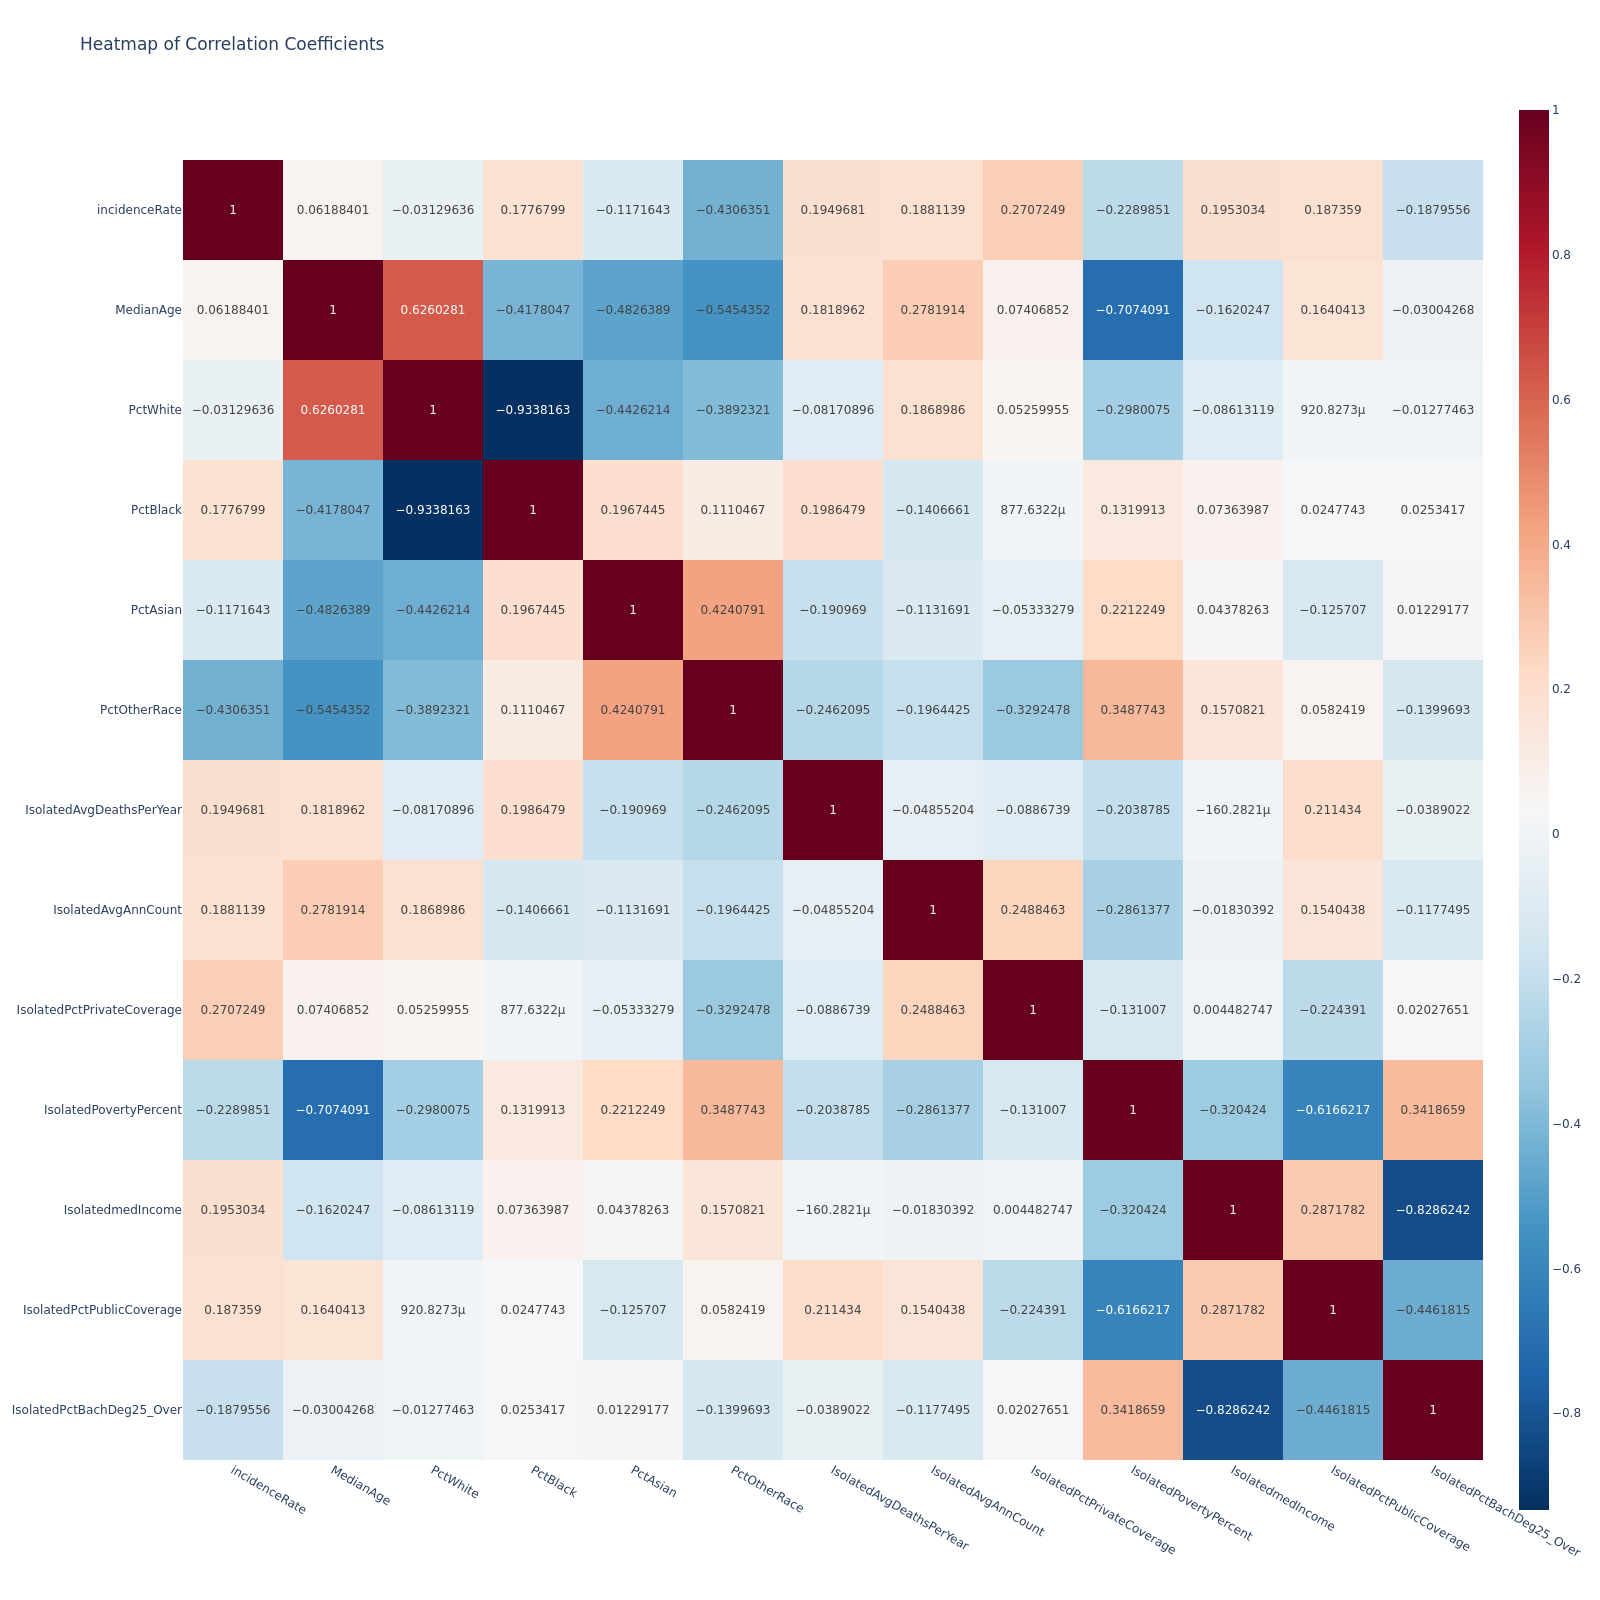

In [111]:
corr_heatmap(df[features_in].corr(numeric_only=True), fig_type="png")

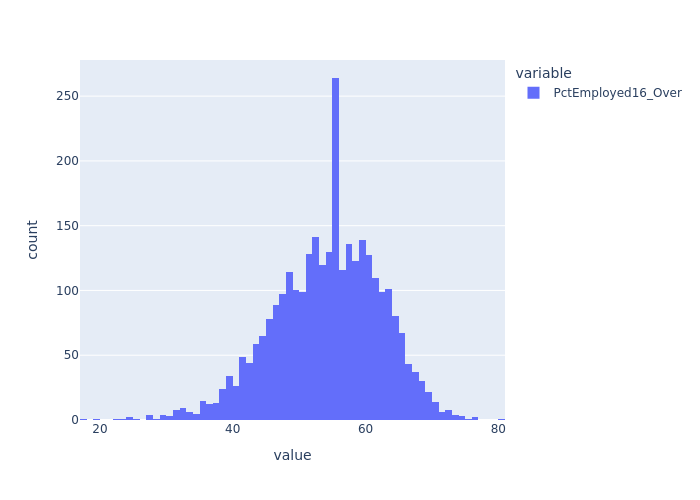

In [112]:
px.histogram(df["PctEmployed16_Over"]).show("png")

In [113]:
def filtering_features_based_on_vif(X: np.ndarray, threshold=15.0, verbose=False):
    """
    Filter features based on Variance Inflation Factor (VIF).
    Features with VIF above the threshold are removed iteratively."""

    if not isinstance(threshold, (int, float)):
        raise ValueError("Threshold must be a numeric value.")
    if not isinstance(verbose, bool):
        raise ValueError("Verbose must be a boolean value.")
    if X.size == 0:
        raise ValueError("Input X cannot be empty.")
    if X.shape[0] < 2:
        raise ValueError("Input X must have at least two samples.")
    if X.shape[1] < 2:
        raise ValueError("Input X must have at least two features.")

    X = np.asanyarray(X)
    features = np.ones(X.shape[1], dtype=bool)
    for _ in range(features.shape[0]):
        vif = np.zeros(features.shape[0])
        mask = np.where(features)
        vif[mask] = [variance_inflation_factor(X[:, features], i) for i in range(X[:, features].shape[1])]
        max_vif = max(vif)
        idx_max_vif = np.argmax(vif)
        if max_vif >= threshold:
            if verbose:
                print(f"Index of feature with max VIF: {idx_max_vif}")
                print(f"Removing feature with VIF: {max_vif}")
            features[idx_max_vif] = False
            continue
        else:
            break
    return features

In [114]:
mask_features = filtering_features_based_on_vif(df[features_in], threshold=5)
filtered_features = [feature for feature, choosen in zip(features_in, mask_features) if choosen]

In [115]:
filtered_features

['PctWhite',
 'PctBlack',
 'PctAsian',
 'PctOtherRace',
 'IsolatedAvgDeathsPerYear',
 'IsolatedAvgAnnCount',
 'IsolatedPctPrivateCoverage',
 'IsolatedPovertyPercent',
 'IsolatedmedIncome',
 'IsolatedPctPublicCoverage',
 'IsolatedPctBachDeg25_Over']

In [116]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

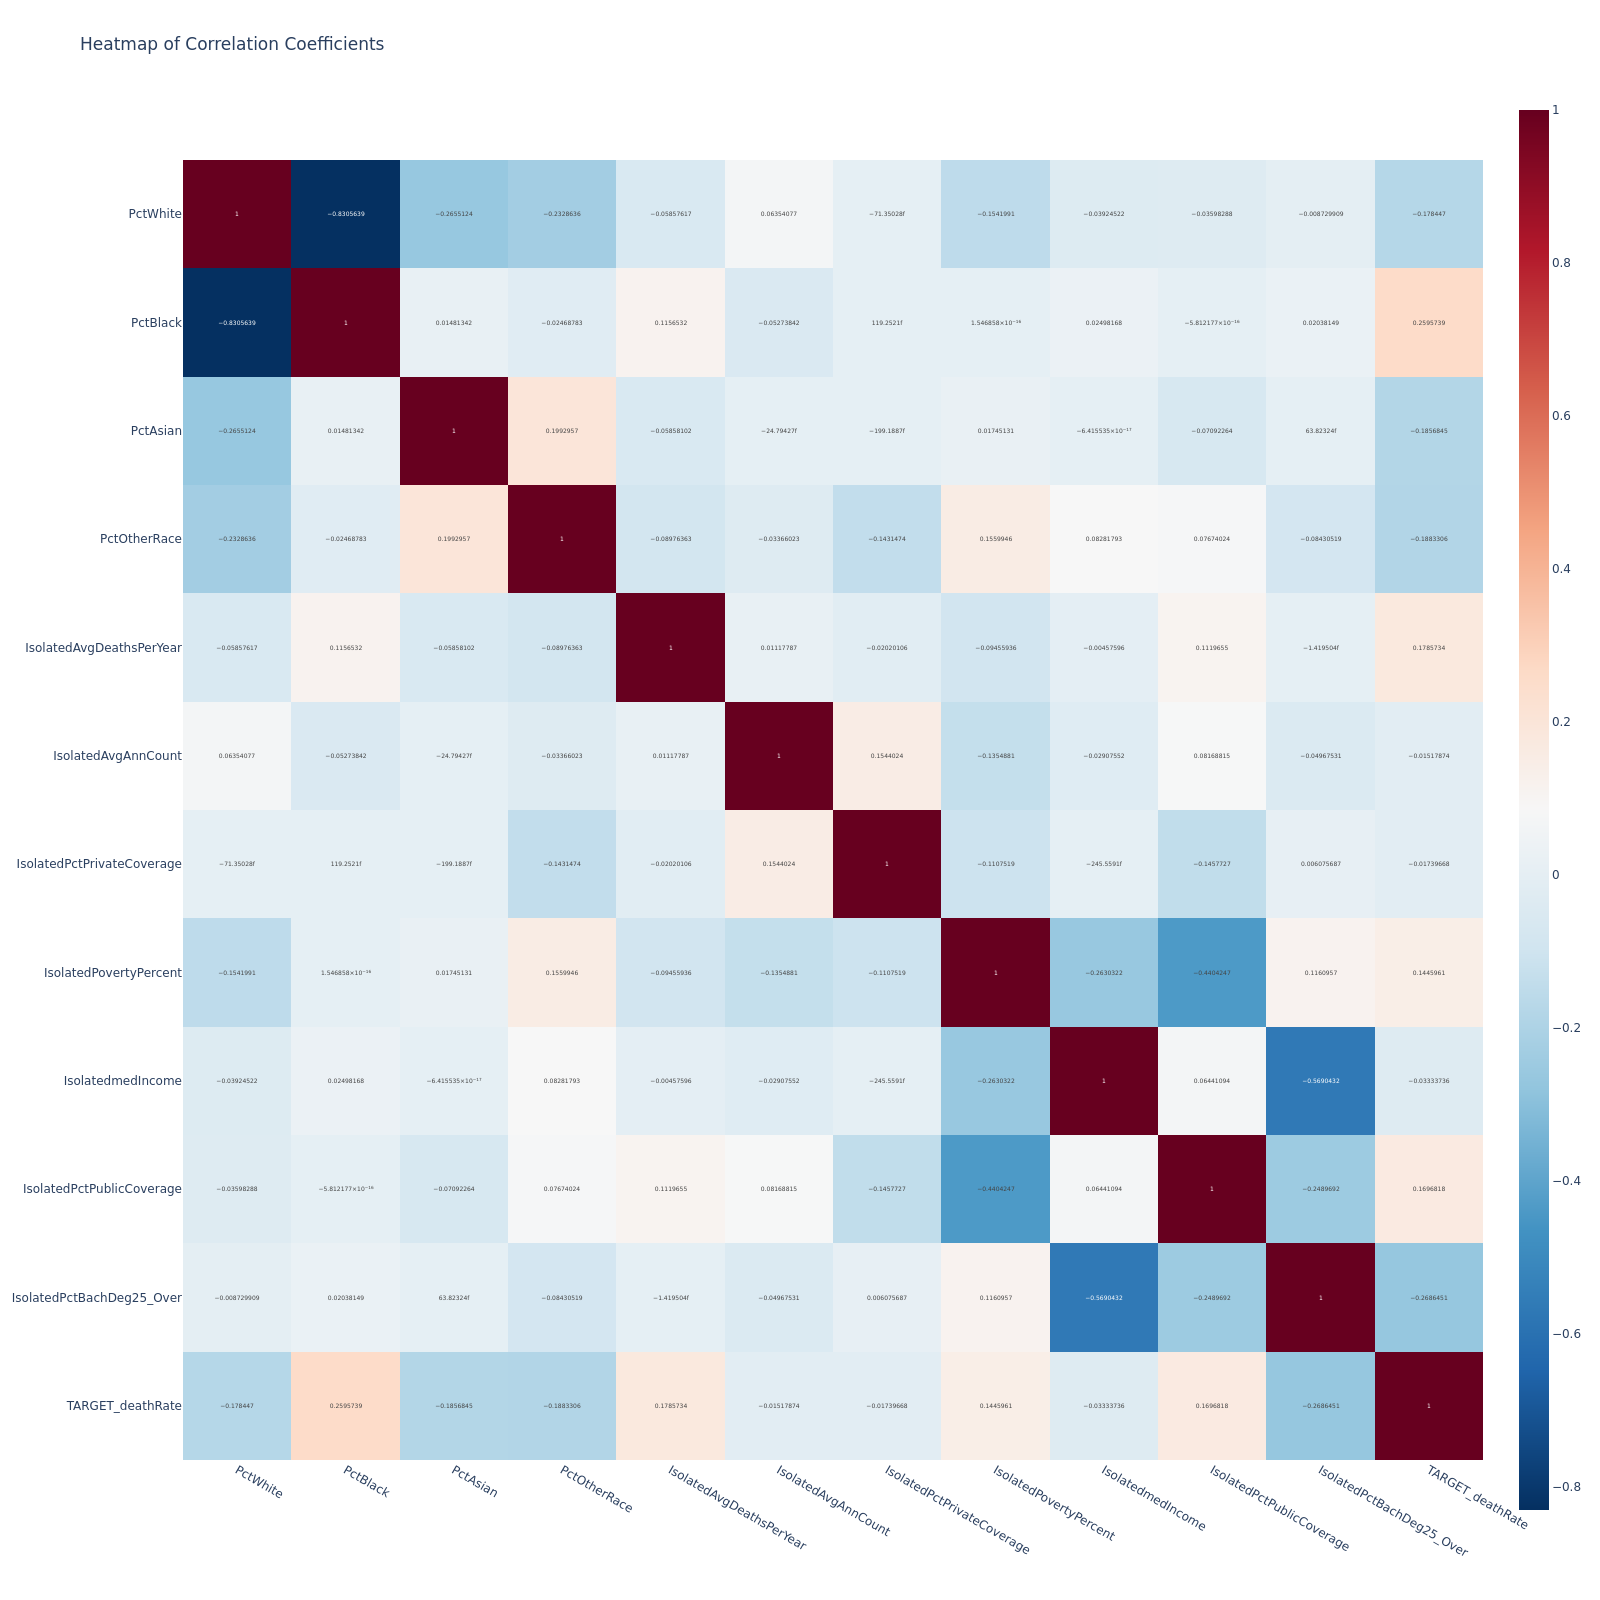

In [117]:
corr_heatmap(df[filtered_features + ["TARGET_deathRate"]], width=1600, height=1600, fig_type="png")

In [118]:
def plot_barplot_corr_with_target(df, target='TARGET_deathRate'):
    corr = df.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

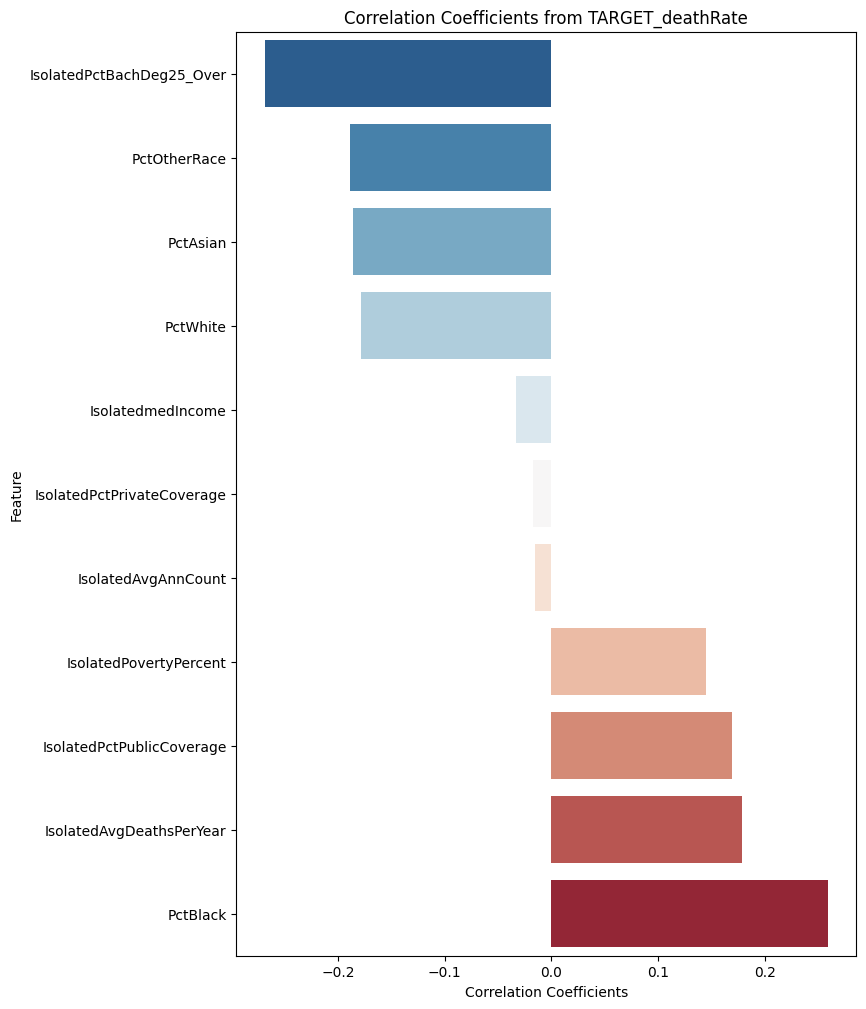

In [119]:
plot_barplot_corr_with_target(df[filtered_features + ['TARGET_deathRate']])

In [120]:
model = LinearRegression()

In [121]:
model.fit(df_train[filtered_features], df_train[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [122]:
y_pred = model.predict(df_test[filtered_features])
y_test = df_test[target]

In [123]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, r2

(552.1270362222374, 0.3062902375950799)

<Axes.ArtistList of 2 lines>

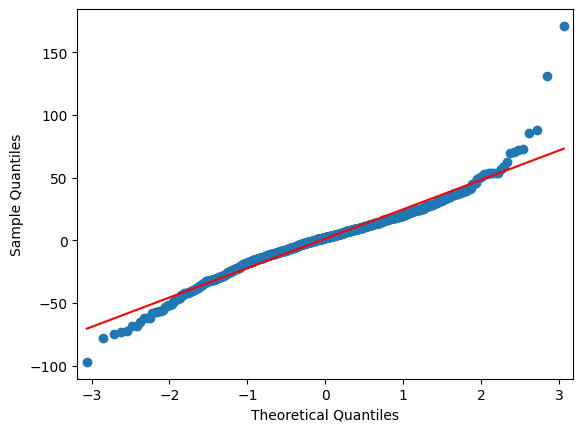

In [124]:
residuals = y_test - y_pred
qqplot(residuals, line='s').gca().lines

In [125]:
# Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, df_test[filtered_features])
print("Goldfeld-Quandt test:")
print(f"F-stat: {gq_test[0]}, p-value: {gq_test[1]}\n")

Goldfeld-Quandt test:
F-stat: 0.9131009000972184, p-value: 0.830191009917135



In [126]:
dw = durbin_watson(residuals)
print(f"Durbin-Watson statistic:", dw)

# DW ≈ 2: No autocorrelation.
# DW < 2: Possible positive autocorrelation.
# DW > 2: Possible negative autocorrelation.

Durbin-Watson statistic: 2.0011509801242435


In [127]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train['TARGET_deathRate'].std()
    return std_coef

In [128]:
model.feature_importance_ = standardize_coefficients(model, df_train)

In [129]:
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,IsolatedPovertyPercent,0.290220
1,IsolatedPctPublicCoverage,0.230134
2,PctBlack,0.205391
3,IsolatedAvgDeathsPerYear,0.120973
4,IsolatedPctPrivateCoverage,0.013895
5,IsolatedAvgAnnCount,-0.025941
6,PctWhite,-0.026851
7,PctAsian,-0.122190
8,IsolatedmedIncome,-0.196492
9,PctOtherRace,-0.237418


In [131]:
X = sm.add_constant(df_train[filtered_features]) # add intercept
y = df_train[target]
model_sm = sm.OLS(y, X).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TARGET_deathRate   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     100.8
Date:                Thu, 24 Jul 2025   Prob (F-statistic):          2.93e-184
Time:                        11:03:50   Log-Likelihood:                -9545.3
No. Observations:                2111   AIC:                         1.911e+04
Df Residuals:                    2099   BIC:                         1.918e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        184.0037      7.291     25.237      0.000     169.706     198.302
PctWhite                      -0.0460      0.076     -0.606      0.545      -0.195       0.103
PctBlack                       0.3944      0.079      5.020      0.000       0.240       0.548
PctAsian                      -1.3167      0.224     -5.891      0.000      -1.755      -0.878
PctOtherRace                  -1.9260      0.167    -11.524      0.000      -2.254      -1.598
IsolatedAvgDeathsPerYear       0.0351      0.005      6.704      0.000       0.025       0.045
IsolatedAvgAnnCount           -0.0014      0.001     -1.431      0.153      -0.003       0.001
IsolatedPctPrivateCoverage     0.0638      0.086      0.740      0.460      -0.105       0.233
IsolatedPovertyPercent         1.8927      0.156     12.158      0.000       1.587       2.198
IsolatedmedIncome             -0.0007   8.75e-05     -8.274      0.000      -0.001      -0.001
IsolatedPctPublicCoverage      1.6294      0.162     10.070      0.000       1.312       1.947
IsolatedPctBachDeg25_Over     -2.7964      0.170    -16.406      0.000      -3.131      -2.462
==============================================================================
Omnibus:                      107.974   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.080
Skew:                           0.036   Prob(JB):                     2.67e-86
Kurtosis:                       5.115   Cond. No.                     1.12e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [134]:
import statsmodels.api as sm
X = sm.add_constant(df_train[filtered_features]) # add intercept
model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       TARGET_deathRate   No. Observations:                 2111
Model:                            GLM   Df Residuals:                     2099
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13051.
Date:                Thu, 24 Jul 2025   Deviance:                       33.574
Time:                        11:04:56   Pearson chi2:                     32.6
No. Iterations:                     5   Pseudo R-squ. (CS):           0.008345
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          5.2182      0.327     15.935      0.000       4.576       5.860
PctWhite                      -0.0003      0.003     -0.098      0.922      -0.007       0.006
PctBlack                       0.0022      0.004      0.612      0.541      -0.005       0.009
PctAsian                      -0.0079      0.010     -0.788      0.431      -0.028       0.012
PctOtherRace                  -0.0105      0.008     -1.399      0.162      -0.025       0.004
IsolatedAvgDeathsPerYear       0.0002      0.000      0.891      0.373      -0.000       0.001
IsolatedAvgAnnCount        -6.937e-06   4.27e-05     -0.162      0.871   -9.07e-05    7.68e-05
IsolatedPctPrivateCoverage     0.0008      0.004      0.217      0.828      -0.007       0.008
IsolatedPovertyPercent         0.0102      0.007      1.463      0.143      -0.003       0.024
IsolatedmedIncome          -4.252e-06   3.93e-06     -1.082      0.279    -1.2e-05    3.45e-06
IsolatedPctPublicCoverage      0.0091      0.007      1.258      0.208      -0.005       0.023
IsolatedPctBachDeg25_Over     -0.0165      0.008     -2.149      0.032      -0.031      -0.001
==============================================================================================
"""

In [135]:
model.predict(df_test[filtered_features])

ValueError: shapes (906,11) and (12,) not aligned: 11 (dim 1) != 12 (dim 0)